In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import math
import io
from pprint import pprint
import os
from sklearn import preprocessing
from datetime import datetime, timedelta
from typing import List
import itertools
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,r2_score

In [2]:
def parse(path: str) -> pd.DataFrame:
    # CSVから読み取る
    try:
        df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])
    except Exception as e:
        raise(e)
    df_target = df.to_numpy()

    # いい感じに整形
    requests = pd.DataFrame([{"date": datetime.fromtimestamp(float(d[4])/1000), "status": d[6], "count": 1} for d in df_target if (d[0] == "REQUEST" and not math.isnan(float(d[4])) )])
    if len(requests) == 0:
        return pd.DataFrame([])

    # 1秒ごとにサマる
    grouped1 = requests.groupby([pd.Grouper(key=("status")),pd.Grouper(key=("date"), freq="S")]).sum().reset_index()

    # 全部同じ数は困るので乱数を入れておく
    for x in range(len(grouped1)):
        grouped1.iat[x, 2] += np.random.rand() * sys.float_info.epsilon

    return grouped1

In [3]:
def reg_tree() -> DecisionTreeRegressor:
    X = [
        [60],
        [100],
        [140],
        [175],
        [210],
        [255],
        [300],
        [330],
        [360],
        [390],
        [420],
        [460],
        [500],
        [540],
        [580],
        [610],
        [640],
        [670],
        [700],
        [730],
        [760],
        [790],
        [820],
        [850],
        [880],
        [910],
        [940],
        [970],
        [1000],
        [1030],
        [1060],
    ]

    y = [
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        26,
        27,
        28,
        29,
        30,
        31,
        32,
        33,
        34,
    ]

    return DecisionTreeRegressor().fit(X, y)

In [4]:
fuzzy_cluster_size_01 = pd.read_csv("../fuzzy20230405/wiki_hpq.log", names=["date", "size"])
fuzzy_cluster_size_01["date"] = pd.to_datetime(fuzzy_cluster_size_01["date"], utc = False) + pd.to_timedelta(9, unit='h')
fuzzy_cluster_size_01

,date,size
0,2023-05-04 23:06:53+00:00,16
1,2023-05-04 23:06:54+00:00,16
2,2023-05-04 23:06:55+00:00,16
3,2023-05-04 23:06:56+00:00,16
4,2023-05-04 23:06:57+00:00,16
...,...,...
1067,2023-05-04 23:27:06+00:00,14
1068,2023-05-04 23:27:07+00:00,14
1069,2023-05-04 23:27:08+00:00,14
1070,2023-05-04 23:27:09+00:00,14


In [5]:
fuzzy_request_01 = parse("../fuzzy20230405/wiki+simulation.log")
fuzzy_request_02 = fuzzy_request_01[fuzzy_request_01["status"] != "KO"]
fuzzy_request_02["date"] = pd.to_datetime(fuzzy_request_02["date"], utc=True)
fuzzy_request_02

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_9380/600845077.py:4: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])


,status,date,count
0,OK,2023-05-04 23:07:09+00:00,254
1,OK,2023-05-04 23:07:10+00:00,425
2,OK,2023-05-04 23:07:11+00:00,469
3,OK,2023-05-04 23:07:12+00:00,472
4,OK,2023-05-04 23:07:13+00:00,510
...,...,...,...
1166,OK,2023-05-04 23:26:35+00:00,394
1167,OK,2023-05-04 23:26:36+00:00,355
1168,OK,2023-05-04 23:26:37+00:00,453
1169,OK,2023-05-04 23:26:38+00:00,400


In [6]:
fuzzy_merged_01 = pd.merge(fuzzy_cluster_size_01, fuzzy_request_02, left_on="date", right_on="date")
fuzzy_merged_01

,date,size,status,count
0,2023-05-04 23:07:10+00:00,16,OK,425
1,2023-05-04 23:07:11+00:00,16,OK,469
2,2023-05-04 23:07:12+00:00,16,OK,472
3,2023-05-04 23:07:13+00:00,16,OK,510
4,2023-05-04 23:07:14+00:00,16,OK,500
...,...,...,...,...
1026,2023-05-04 23:26:34+00:00,15,OK,398
1027,2023-05-04 23:26:35+00:00,15,OK,394
1028,2023-05-04 23:26:36+00:00,15,OK,355
1029,2023-05-04 23:26:38+00:00,15,OK,400


In [7]:
fuzzy_merged_02 = fuzzy_merged_01
fuzzy_merged_02["expected_size"] = fuzzy_merged_01["count"].map(lambda x: reg_tree().predict([[x]])[0])
fuzzy_merged_02["diff"] = abs(fuzzy_merged_02["size"] - fuzzy_merged_02["expected_size"])
fuzzy_merged_02


,date,size,status,count,expected_size,diff
0,2023-05-04 23:07:10+00:00,16,OK,425,14.0,2.0
1,2023-05-04 23:07:11+00:00,16,OK,469,15.0,1.0
2,2023-05-04 23:07:12+00:00,16,OK,472,15.0,1.0
3,2023-05-04 23:07:13+00:00,16,OK,510,16.0,0.0
4,2023-05-04 23:07:14+00:00,16,OK,500,16.0,0.0
...,...,...,...,...,...,...
1026,2023-05-04 23:26:34+00:00,15,OK,398,13.0,2.0
1027,2023-05-04 23:26:35+00:00,15,OK,394,13.0,2.0
1028,2023-05-04 23:26:36+00:00,15,OK,355,12.0,3.0
1029,2023-05-04 23:26:38+00:00,15,OK,400,13.0,2.0


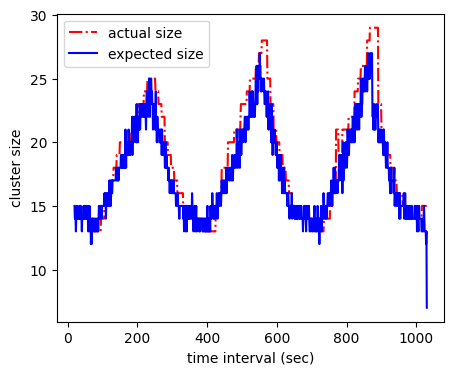

In [30]:
plt.xlabel(xlabel="time interval (sec)")
plt.ylabel(ylabel="cluster size")

plt.plot([k for k, v in enumerate(fuzzy_merged_02["date"])][20:], fuzzy_merged_02["size"][20:], color="red", linestyle='dashdot', label='actual size')
plt.plot([k for k, v in enumerate(fuzzy_merged_02["date"])][20:], fuzzy_merged_02["expected_size"][20:], color="blue", label='expected size')

plt.gcf().set_size_inches(5, 4)
plt.legend()

plt.savefig("wiki_fuzzy_20240422.png")

In [9]:
mean_squared_error(fuzzy_merged_02["size"], fuzzy_merged_02["expected_size"])

3.51988360814743

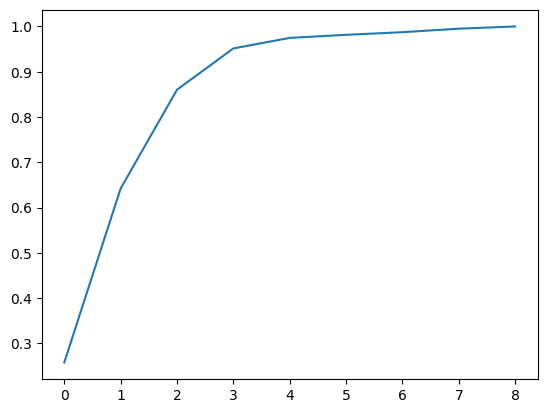

In [18]:
fuzzy_pmf = fuzzy_merged_02['diff'].value_counts(normalize=True).sort_index()
fuzzy_cdf = np.cumsum(fuzzy_pmf)
plt.plot(fuzzy_cdf)

In [11]:
std_cluster_size_01 = pd.read_csv("hpq_20221116151815.log", names=["date", "size"])
std_cluster_size_01

,date,size
0,2022-11-16T15:18:10+00:00,14
1,2022-11-16T15:18:11+00:00,14
2,2022-11-16T15:18:12+00:00,14
3,2022-11-16T15:18:13+00:00,14
4,2022-11-16T15:18:14+00:00,14
...,...,...
1021,2022-11-16T15:37:36+00:00,15
1022,2022-11-16T15:37:37+00:00,15
1023,2022-11-16T15:37:38+00:00,15
1024,2022-11-16T15:37:39+00:00,15


In [12]:
std_cluster_size_02 = std_cluster_size_01
std_cluster_size_02["date"] = pd.to_datetime(std_cluster_size_02["date"], utc = False) + pd.to_timedelta(9, unit='h')
std_cluster_size_02

,date,size
0,2022-11-17 00:18:10+00:00,14
1,2022-11-17 00:18:11+00:00,14
2,2022-11-17 00:18:12+00:00,14
3,2022-11-17 00:18:13+00:00,14
4,2022-11-17 00:18:14+00:00,14
...,...,...
1021,2022-11-17 00:37:36+00:00,15
1022,2022-11-17 00:37:37+00:00,15
1023,2022-11-17 00:37:38+00:00,15
1024,2022-11-17 00:37:39+00:00,15


In [13]:
std_request_01 = parse("simulation_ba2.log")
std_request_02 = std_request_01[std_request_01["status"] != "KO"]
std_request_02["date"] = pd.to_datetime(std_request_02["date"], utc=True)
std_request_02

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_9380/600845077.py:4: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_9380/3658772405.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std_request_02["date"] = pd.to_datetime(std_request_02["date"], utc=True)


,status,date,count
16,OK,2022-11-17 00:18:09+00:00,194.0
17,OK,2022-11-17 00:18:10+00:00,457.0
18,OK,2022-11-17 00:18:11+00:00,541.0
19,OK,2022-11-17 00:18:12+00:00,472.0
20,OK,2022-11-17 00:18:13+00:00,501.0
...,...,...,...
1182,OK,2022-11-17 00:37:35+00:00,411.0
1183,OK,2022-11-17 00:37:36+00:00,446.0
1184,OK,2022-11-17 00:37:37+00:00,402.0
1185,OK,2022-11-17 00:37:38+00:00,411.0


In [14]:
std_merged_01 = pd.merge(std_cluster_size_02, std_request_02, left_on="date", right_on="date")
std_merged_02 = std_merged_01
std_merged_02["expected_size"] = std_merged_01["count"].map(lambda x: reg_tree().predict([[x]])[0])
std_merged_02["diff"] = abs(std_merged_02["size"] - std_merged_02["expected_size"])
std_merged_02


,date,size,status,count,expected_size,diff
0,2022-11-17 00:18:10+00:00,14,OK,457.0,15.0,1.0
1,2022-11-17 00:18:11+00:00,14,OK,541.0,17.0,3.0
2,2022-11-17 00:18:12+00:00,14,OK,472.0,15.0,1.0
3,2022-11-17 00:18:13+00:00,14,OK,501.0,16.0,2.0
4,2022-11-17 00:18:14+00:00,14,OK,441.0,15.0,1.0
...,...,...,...,...,...,...
1020,2022-11-17 00:37:35+00:00,16,OK,411.0,14.0,2.0
1021,2022-11-17 00:37:36+00:00,15,OK,446.0,15.0,0.0
1022,2022-11-17 00:37:37+00:00,15,OK,402.0,13.0,2.0
1023,2022-11-17 00:37:38+00:00,15,OK,411.0,14.0,1.0


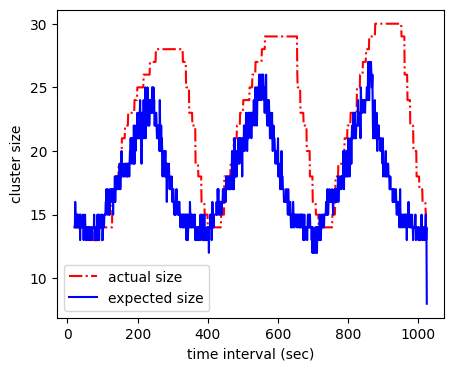

In [31]:
plt.xlabel(xlabel="time interval (sec)")
plt.ylabel(ylabel="cluster size")

plt.plot([k for k, v in enumerate(std_merged_02["date"])][20:], std_merged_02["size"][20:], color="red", linestyle='dashdot', label='actual size')
plt.plot([k for k, v in enumerate(std_merged_02["date"])][20:], std_merged_02["expected_size"][20:], color="blue", label='expected size')

plt.gcf().set_size_inches(5, 4)
plt.legend()

plt.savefig("wiki_std_20240422.png")

In [15]:
mean_squared_error(std_merged_02["size"], std_merged_02["expected_size"])


43.940487804878046

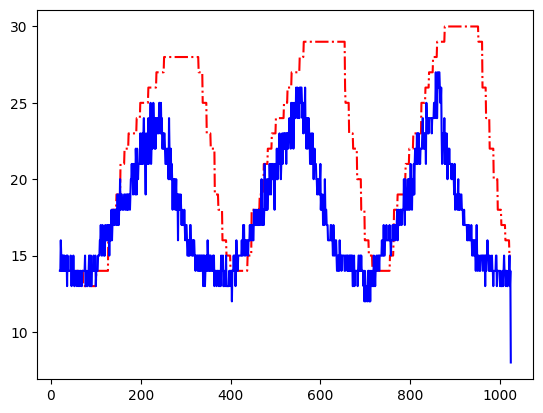

In [17]:
plt.plot([k for k, v in enumerate(std_merged_02["date"])][20:], std_merged_02["size"][20:], color="red", linestyle='dashdot', label='actual size')
plt.plot([k for k, v in enumerate(std_merged_02["date"])][20:], std_merged_02["expected_size"][20:], color="blue", label='expected size')

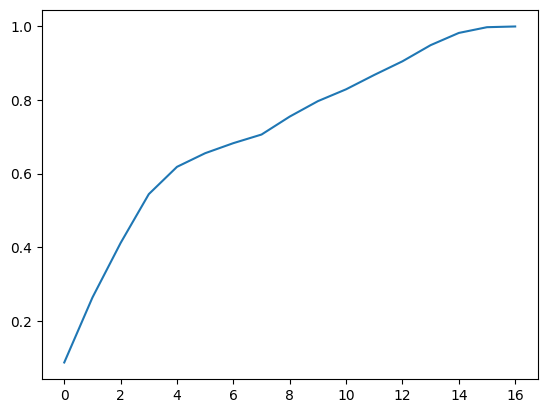

In [19]:
std_pmf = std_merged_02['diff'].value_counts(normalize=True).sort_index()
std_cdf = np.cumsum(std_pmf)
plt.plot(std_cdf)

In [20]:
sampen_cluster_size_01 = pd.read_csv("hpq_20221116144838.log", names=["date", "size"])
sampen_cluster_size_01

,date,size
0,2022-11-16T14:49:55+00:00,14
1,2022-11-16T14:49:56+00:00,14
2,2022-11-16T14:49:57+00:00,14
3,2022-11-16T14:49:58+00:00,14
4,2022-11-16T14:50:00+00:00,14
...,...,...
1022,2022-11-16T15:09:20+00:00,13
1023,2022-11-16T15:09:21+00:00,13
1024,2022-11-16T15:09:22+00:00,13
1025,2022-11-16T15:09:23+00:00,13


In [21]:
sampen_cluster_size_02 = sampen_cluster_size_01
sampen_cluster_size_02["date"] = pd.to_datetime(sampen_cluster_size_02["date"], utc = False) + pd.to_timedelta(9, unit='h')
sampen_cluster_size_02

,date,size
0,2022-11-16 23:49:55+00:00,14
1,2022-11-16 23:49:56+00:00,14
2,2022-11-16 23:49:57+00:00,14
3,2022-11-16 23:49:58+00:00,14
4,2022-11-16 23:50:00+00:00,14
...,...,...
1022,2022-11-17 00:09:20+00:00,13
1023,2022-11-17 00:09:21+00:00,13
1024,2022-11-17 00:09:22+00:00,13
1025,2022-11-17 00:09:23+00:00,13


In [22]:
sampen_request_01 = parse("simulation_bse.log")
sampen_request_02 = sampen_request_01[sampen_request_01["status"] != "KO"]
sampen_request_02["date"] = pd.to_datetime(sampen_request_02["date"], utc=True)
sampen_request_02

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_9380/600845077.py:4: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_9380/1770829219.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampen_request_02["date"] = pd.to_datetime(sampen_request_02["date"], utc=True)


,status,date,count
11,OK,2022-11-16 23:49:54+00:00,319
12,OK,2022-11-16 23:49:55+00:00,479
13,OK,2022-11-16 23:49:56+00:00,503
14,OK,2022-11-16 23:49:57+00:00,482
15,OK,2022-11-16 23:49:58+00:00,441
...,...,...,...
1177,OK,2022-11-17 00:09:20+00:00,421
1178,OK,2022-11-17 00:09:21+00:00,376
1179,OK,2022-11-17 00:09:22+00:00,405
1180,OK,2022-11-17 00:09:23+00:00,415


In [23]:
sampen_merged_01 = pd.merge(sampen_cluster_size_02, sampen_request_02, left_on="date", right_on="date")
sampen_merged_02 = sampen_merged_01
sampen_merged_02["expected_size"] = sampen_merged_01["count"].map(lambda x: reg_tree().predict([[x]])[0])
sampen_merged_02["diff"] = abs(sampen_merged_02["size"] - sampen_merged_02["expected_size"])
sampen_merged_02


,date,size,status,count,expected_size,diff
0,2022-11-16 23:49:55+00:00,14,OK,479,15.0,1.0
1,2022-11-16 23:49:56+00:00,14,OK,503,16.0,2.0
2,2022-11-16 23:49:57+00:00,14,OK,482,16.0,2.0
3,2022-11-16 23:49:58+00:00,14,OK,441,15.0,1.0
4,2022-11-16 23:50:00+00:00,14,OK,444,15.0,1.0
...,...,...,...,...,...,...
1022,2022-11-17 00:09:20+00:00,13,OK,421,14.0,1.0
1023,2022-11-17 00:09:21+00:00,13,OK,376,13.0,0.0
1024,2022-11-17 00:09:22+00:00,13,OK,405,13.0,0.0
1025,2022-11-17 00:09:23+00:00,13,OK,415,14.0,1.0


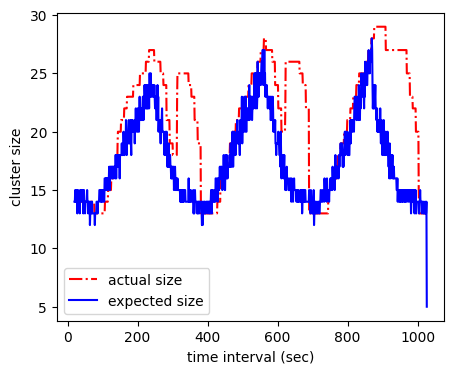

In [32]:
plt.xlabel(xlabel="time interval (sec)")
plt.ylabel(ylabel="cluster size")

plt.plot([k for k, v in enumerate(sampen_merged_02["date"])][20:], sampen_merged_02["size"][20:], color="red", linestyle='dashdot', label='actual size')
plt.plot([k for k, v in enumerate(sampen_merged_02["date"])][20:], sampen_merged_02["expected_size"][20:], color="blue", label='expected size')

plt.gcf().set_size_inches(5, 4)
plt.legend()

plt.savefig("wiki_sampen_20240422.png")

In [24]:
mean_squared_error(sampen_merged_02["size"], sampen_merged_02["expected_size"])


28.748782862706914

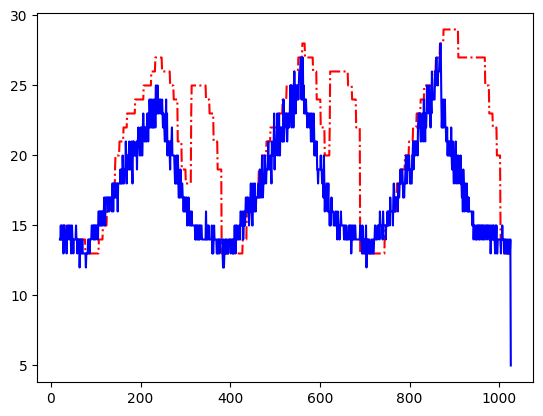

In [25]:
plt.plot([k for k, v in enumerate(sampen_merged_02["date"])][20:], sampen_merged_02["size"][20:], color="red", linestyle='dashdot', label='actual size')
plt.plot([k for k, v in enumerate(sampen_merged_02["date"])][20:], sampen_merged_02["expected_size"][20:], color="blue", label='expected size')

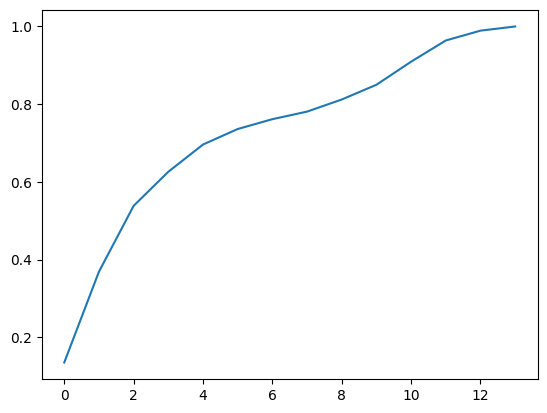

In [26]:
sampen_pmf = sampen_merged_02['diff'].value_counts(normalize=True).sort_index()
sampen_cdf = np.cumsum(sampen_pmf)
plt.plot(sampen_cdf)

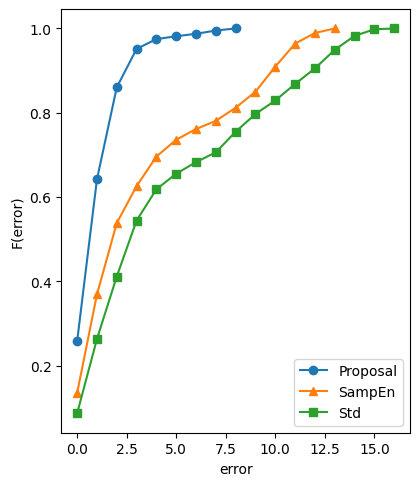

In [29]:
plt.xlabel(xlabel="error")
plt.ylabel(ylabel="F(error)")

plt.plot(fuzzy_cdf, "o-", label='Proposal')
plt.plot(sampen_cdf, "^-", label='SampEn')
plt.plot(std_cdf, "s-", label='Std')

plt.gcf().set_size_inches(4.5, 5.5)
plt.legend()

plt.savefig("wiki2015_june26_cdf.png")